In [ ]:
#install Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdrasedhasanrokon","key":"4ac4427228b2ec48d085d8d73c970b2a"}'}

In [ ]:
! mkdir /root/.kaggle_new



In [ ]:
! sudo mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                  title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                       1KB  2024-08-14 11:02:45           5078         94  1.0              
haseebindata/student-performance-predictions                         Student Performance Predictions                  9KB  2024-08-17 06:57:57           5523        118  0.9411765        
cvergnolle/gold-price-and-relevant-metrics                           Gold Price & Relevant Metrics                   36KB  2024-08-13 22:08:02           1337         21  1.0              
uom190346a/sleep-and-health-metrics                         

In [ ]:
! kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

Dataset URL: https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda
License(s): unknown
animal-image-datasetdog-cat-and-panda.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip animal-image-datasetdog-cat-and-panda.zip

Streaming output truncated to the last 5000 lines.
  inflating: animals/animals/dogs/dogs_00007.jpg  
  inflating: animals/animals/dogs/dogs_00008.jpg  
  inflating: animals/animals/dogs/dogs_00009.jpg  
  inflating: animals/animals/dogs/dogs_00010.jpg  
  inflating: animals/animals/dogs/dogs_00011.jpg  
  inflating: animals/animals/dogs/dogs_00012.jpg  
  inflating: animals/animals/dogs/dogs_00013.jpg  
  inflating: animals/animals/dogs/dogs_00014.jpg  
  inflating: animals/animals/dogs/dogs_00015.jpg  
  inflating: animals/animals/dogs/dogs_00016.jpg  
  inflating: animals/animals/dogs/dogs_00017.jpg  
  inflating: animals/animals/dogs/dogs_00018.jpg  
  inflating: animals/animals/dogs/dogs_00019.jpg  
  inflating: animals/animals/dogs/dogs_00020.jpg  
  inflating: animals/animals/dogs/dogs_00021.jpg  
  inflating: animals/animals/dogs/dogs_00022.jpg  
  inflating: animals/animals/dogs/dogs_00023.jpg  
  inflating: animals/animals/dogs/dogs_00024.jpg  
  inflating: animals/animals/do

In [ ]:
import os
import random
import cv2 as cv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
import nbformat
from PIL import Image

In [ ]:
TRAIN_DIR = './animals/animals'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['cats', 'panda', 'dogs']


In [ ]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv.imread(os.path.join(path, img))

        # Resize image to 32x32 using bilinear interpolation
        img_arr = cv.resize(img_arr, (32, 32), interpolation=cv.INTER_AREA)

        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 1000/1000 [00:01<00:00, 563.18it/s]

3000


In [ ]:
random.shuffle(TRAIN_DATA)

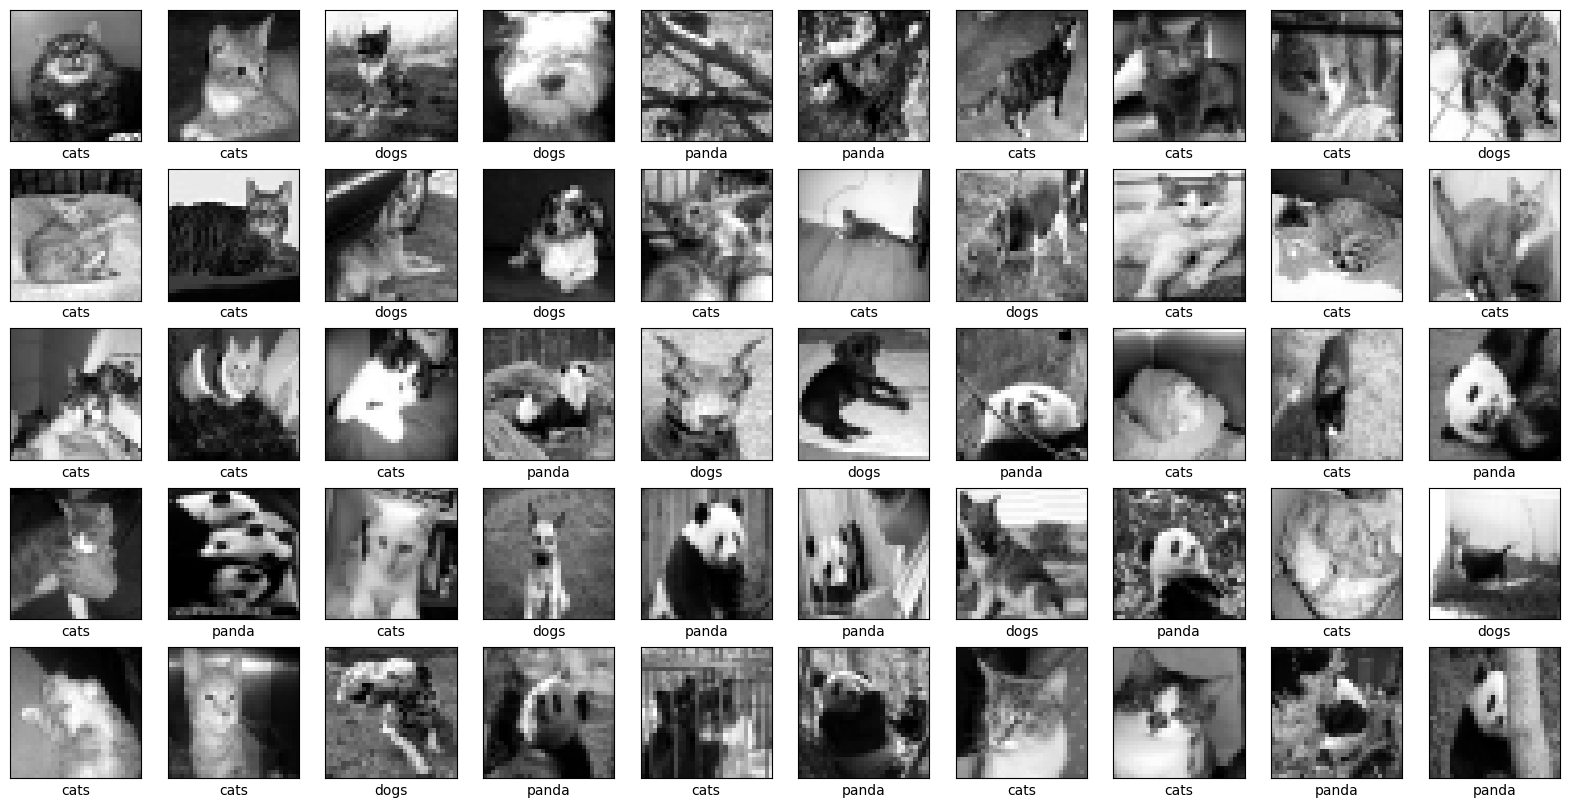

In [ ]:
plt.figure(figsize=(20,10))

for i in range(50):
  plt.subplot(5, 10, i+1)
  image = TRAIN_DATA[i][0]
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert image to grayscale
  plt.imshow(image_gray, cmap="gray")
  plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
  plt.xticks([])
  plt.yticks([])
  plt.axis()
  if i == 50:
    break
plt.show()

In [ ]:
f1 = TRAIN_DATA[0:600]
f2 = TRAIN_DATA[600:1200]
f3 = TRAIN_DATA[1200:1800]
f4 = TRAIN_DATA[1800:2400]
f5 = TRAIN_DATA[2400:3000]

In [ ]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

In [ ]:
top_filter = 20
def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold):
        temp_dist_list = []
        for train in train_fold:
            l1_dist = np.sum(np.abs(valid[0]-train[0]))
            l2_dist = np.sqrt(np.sum(valid[0]-train[0]**2))
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]

In [ ]:
k_range = 20
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1
            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

In [ ]:
dist_by_fold = []
import math
for i in range(1,6,1):
    if i==1:
        train = f1+f2+f3+f4
        validation = f5
    elif i==2:
        train = f1+f2+f3+f5
        validation = f4
    elif i==3:
        train = f1+f2+f4+f5
        validation = f3
    elif i==4:
        train = f1+f3+f4+f5
        validation = f2
    elif i==5:
        train = f2+f3+f4+f5
        validation = f1

    dist_by_fold.append(distance_calc(train, validation))

100%|██████████| 600/600 [00:44<00:00, 13.49it/s]


In [ ]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

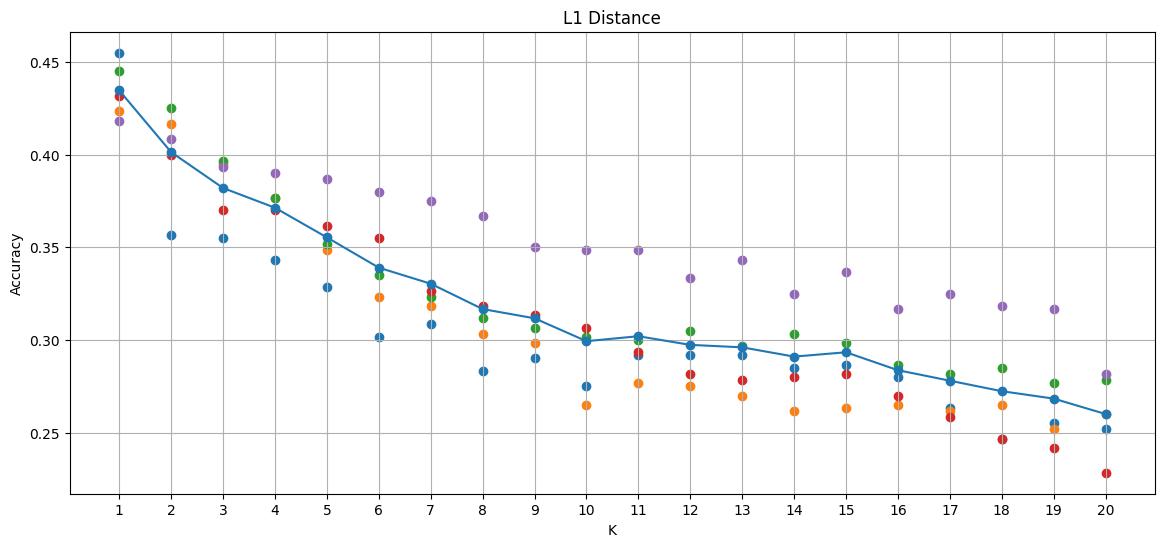

In [ ]:
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend, fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

<Figure size 1400x600 with 0 Axes>

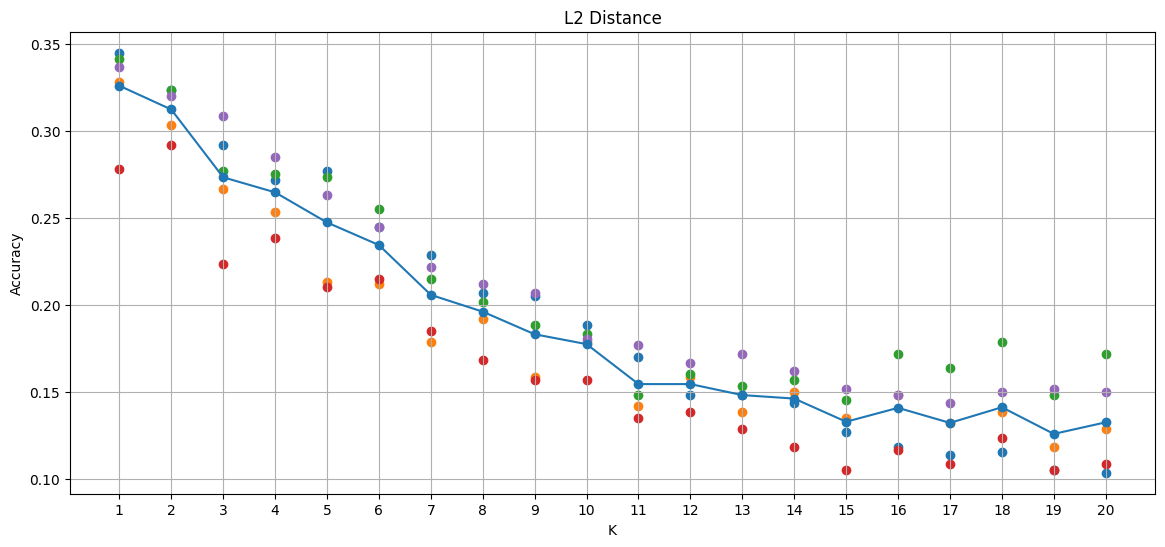

In [ ]:
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

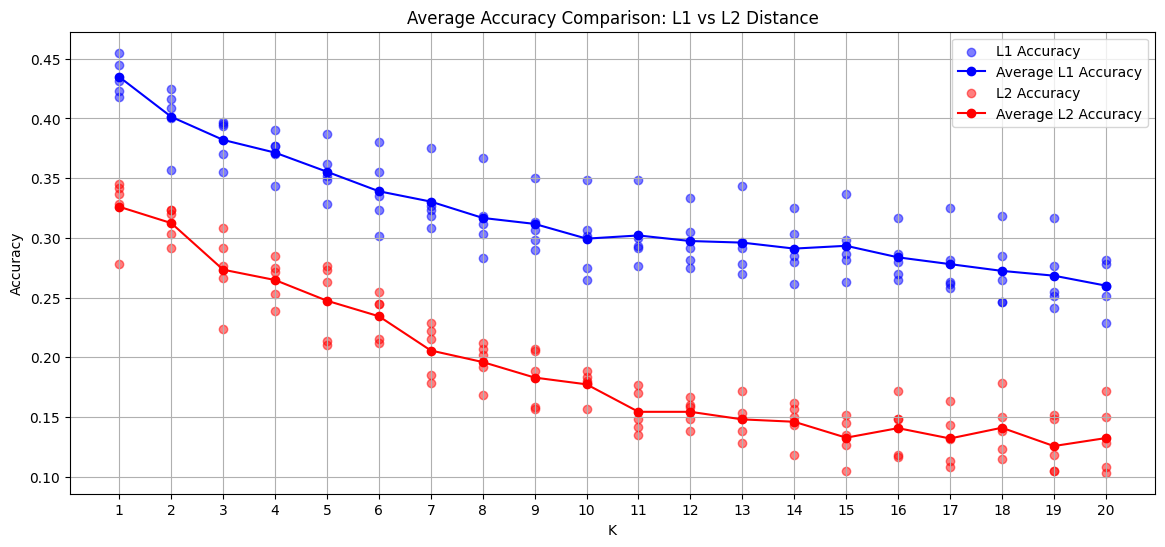

In [ ]:
x_list = list(range(1, k_range + 1))
plt.figure(figsize=(14, 6))

# Calculate average accuracy across all folds for each k value
l1_arr = [[fold[0][i] for fold in accuracies] for i in range(k_range)]
l2_arr = [[fold[1][i] for fold in accuracies] for i in range(k_range)]

l1_average_accuracy = [np.mean(a) for a in l1_arr]
l2_average_accuracy = [np.mean(a) for a in l2_arr]

# Plotting the L1 accuracy
for fold in accuracies:
    plt.scatter(x_list, fold[0], color='blue', alpha=0.5, label='L1 Accuracy' if fold == accuracies[0] else "")

# Plotting the trend line (average accuracy for L1)
plt.plot(x_list, l1_average_accuracy, '-o', label='Average L1 Accuracy', color='blue')

# Plotting the L2 accuracy
for fold in accuracies:
    plt.scatter(x_list, fold[1], color='red', alpha=0.5, label='L2 Accuracy' if fold == accuracies[0] else "")

# Plotting the trend line (average accuracy for L2)
plt.plot(x_list, l2_average_accuracy, '-o', label='Average L2 Accuracy', color='red')

plt.title('Average Accuracy Comparison: L1 vs L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Discussion:

The line chart compares the average accuracy of using L1 (Manhattan) and L2 (Euclidean) distances for an image classification task on the CIFAR-10 dataset, using 5-fold cross-validation. The x-axis shows different values of K, while the y-axis shows accuracy. The Manhattan distance performed better, reaching its highest accuracy of 46% when K=1. In comparison, the Euclidean distance peaked at 36% accuracy when K=1. This indicates that L1 distance was more effective than L2 distance in this case. L1 distance is more robust against outliers in the data and is computationally more efficient because it only calculates absolute differences, without needing to square values or take square roots. Additionally, L1 distance can help identify important features in the data by focusing on those most predictive for classification.

Limitations:

One limitation is the use of grayscale images, which reduces the amount of feature information available, possibly affecting classification accuracy. The simplicity of the KNN model also poses a challenge, as it relies heavily on the choice of K and the distance metric, making it less effective at capturing complex patterns in the data. Additionally, although 5-fold cross-validation is a good practice, it may not evenly distribute class samples, potentially leading to biased results.

Improvements:

To improve accuracy, better feature extraction methods could be used to retain more important information in grayscale images. Exploring more advanced models, like Convolutional Neural Networks (CNNs), could also lead to better performance. Additionally, fine-tuning the K values and distance metrics could further enhance accuracy, with this dataset showing that smaller K values work better with the chosen distance metrics.

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'dogs' with L1 distance 0.00
Prediction 2: Class 'panda' with L1 distance 698.87
Prediction 3: Class 'cats' with L1 distance 730.53
Prediction 4: Class 'cats' with L1 distance 744.03
Prediction 5: Class 'panda' with L1 distance 750.82

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'dogs' with L2 distance 0.00
Prediction 2: Class 'cats' with L2 distance 304.68
Prediction 3: Class 'dogs' with L2 distance 304.96
Prediction 4: Class 'cats' with L2 distance 305.59
Prediction 5: Class 'dogs' with L2 distance 309.33


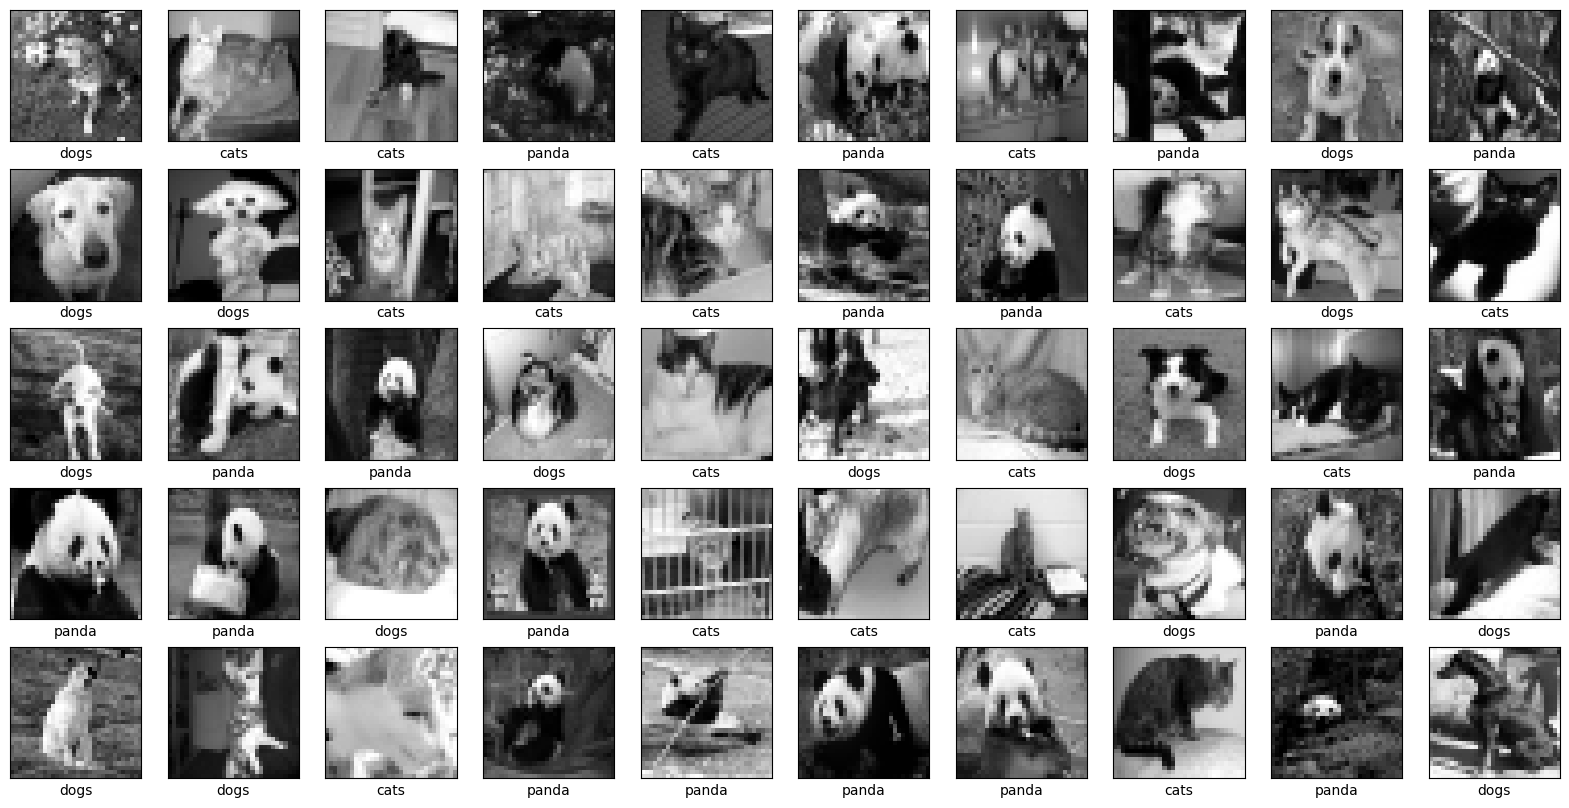

In [ ]:
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49:
        break
test_images = []

for i in range(1000):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
    test_images.append(test_image_gray)

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray, train_image_gray)
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0])

    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break


print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray, train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")
    break